<img style="float: left; padding-right: 10px; width: 45px" src="https://upload.wikimedia.org/wikipedia/fr/b/b1/Logo_EPF.png?raw=true"> 

**Introduction to Machine Learning - P2025: Energy & Environment**
# Lab / TP 1 EXTRA:  Multiple and Polynomial Regression
*Credits*: Adapted from MDE's "Intro to ML" course by Y. Idrissi and I. Chafai.

**First name:**

**Last name:**

**Group:**


---

# Abstract

`statsmodels` is focused on the _inference_ task: guess good values for the betas and discuss how certain you are in those answers. 

`sklearn` is focused on the _prediction_ task: given \[new\] data, guess what the response value is. As a result, statsmodels has lots of tools to discuss confidence, but isn't great at dealing with test sets. Sklearn is great at test sets and validations, but can't really discuss uncertainty in the parameters or predictions. In short:

  - sklearn is about putting a line through it and predicting new values using that line. If the line gives good predictions on the test set, who cares about anything else?
  - statsmodels assumes more about how the data were generated, and (if the assumptions are correct) can tell you about uncertainty in the results


# Learning Goals
After this lab, you should be able to
 - Implement arbitrary multiple regression models in both sklearn and Statsmodels
 - Interpret the coefficent estimates produced by each model, including transformed and dummy variables

# Table of Contents
* Glossary
* Polynomial Regression, and Revisiting the Cab Data
* Multiple regression and exploring the Football data 
* A nice trick for forward-backwards

In [21]:
#importing all the useful libraries as usual
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import statsmodels.api as sm
from statsmodels.api import OLS

from sklearn import preprocessing
from sklearn.preprocessing import PolynomialFeatures
from sklearn.metrics import r2_score
from sklearn.model_selection import train_test_split

from pandas.plotting import scatter_matrix

import seaborn as sns


%matplotlib inline

# Glossary


- **R-squared**: An interpretable summary of how well the model did. 1 is perfect, 0 is a trivial baseline model, negative is worse than the trivial model
- **F-statistic**: A value testing whether we're likely to see these results (or even stronger ones) if none of the predictors actually mattered.
- **Prob (F-statistic)**: The probability that we'd see these results (or even stronger ones) if none of the predictors actually mattered. If this probability is small then either A) some combination of predictors actually matters or B) something rather unlikely has happened
- **coef**: The estimate of each beta. This has several sub-components:
  - **std err**: The amount we'd expect this value to wiggle if we re-did the data collection and re-ran our model. More data tends to make this wiggle smaller, but sometimes the collected data just isn't enough to pin down a particular value.
  - **t and P>|t|**: similar to the F-statistic, these measure the probability of seeing coefficients this big (or even bigger) if the given variable didn't actually matter. Small probability doesn't necessarily mean the value matters
  - **\[0.025 0.975\]**: Endpoints of the 95% confidence interval. This is a interval drawn in a clever way and which gives an idea of where the true beta value might plausibly live. (If you want to understand why "there's a 95% chance the true beta is in the interval" is _wrong_, [check this explanation.](https://datatab.fr/tutorial/confidence-interval) )
  

# Part 1: Polynomial Regression, and Revisiting the Cab Data

In this part we'll be working on cab data. The next cell loads the data as a `pd.DataFrame` and shows a few rows from it.

In [22]:
# read in the data
cab_df = pd.read_csv("cab_data.txt")
cab_df.head()

,TimeMin,PickupCount
0,860.0,33.0
1,17.0,75.0
2,486.0,13.0
3,300.0,5.0
4,385.0,10.0


In [23]:
cab_df.shape

(1250, 2)

Remember it is important to split a test set for model evaluation later. The next cell does that:

In [24]:
train_data, test_data = train_test_split(cab_df, test_size=.2, random_state=42)

The next cell prepares the arrays for `sklearn`.

In [25]:
# do some data cleaning
X_train = train_data['TimeMin'].values.reshape(-1,1)/60
y_train = train_data['PickupCount'].values

X_test = test_data['TimeMin'].values.reshape(-1,1)/60
y_test = test_data['PickupCount'].values

Now let's create a linear model and fit it:

In [26]:
from sklearn.linear_model import LinearRegression
fitted_cab_model0 = LinearRegression().fit(X_train, y_train)


Here goes a plotting function to plot our datapoints together wiht the fitted regression line:

In [27]:

def plot_cabs(cur_model, poly_transformer=None):
    
    # build the x values for the prediction line
    x_vals = np.arange(0,24,.1).reshape(-1,1)
    
    # if needed, build the design matrix
    if poly_transformer:
        design_mat = poly_transformer.fit_transform(x_vals)
        design_mat_test = poly_transformer.fit_transform(X_test)
    else:
        design_mat = x_vals
        design_mat_test = X_test
    
    # make the prediction at each x value
    prediction = cur_model.predict(design_mat)

    # compute residuals for datapoints
    residual = y_test - cur_model.predict(design_mat_test)
    
    # plot the prediction line, and the test data
    fig, (ax1, ax2) = plt.subplots(1,2,figsize=(10,5), sharex=True)
    ax1.plot(x_vals,prediction, '.-', color='k', label="Prediction")
    ax1.scatter(X_test, y_test, label="Test Data")
    # same, but plotting residuals instead
    ax2.scatter(X_test, residual, label="Residuals (test data)")
    ax2.axhline(0, color='k')

    # label your plots
    ax1.set_title('Data points and regression curve')
    ax1.set_ylabel("Number of Taxi Pickups")
    ax1.set_xlabel("Time of Day (Hours Past Midnight)")
    ax1.legend()

    ax2.set_title("Residuals for the Cubic Model")
    ax2.set_ylabel("Residual Number of Taxi Pickups")
    ax2.set_xlabel("Time of Day (Hours Past Midnight)")
    ax2.legend()

    fig.show()

Calling the function on the data gives us a plot:

C:\Users\tdrumond\AppData\Local\Temp\ipykernel_12888\1318629703.py:39: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


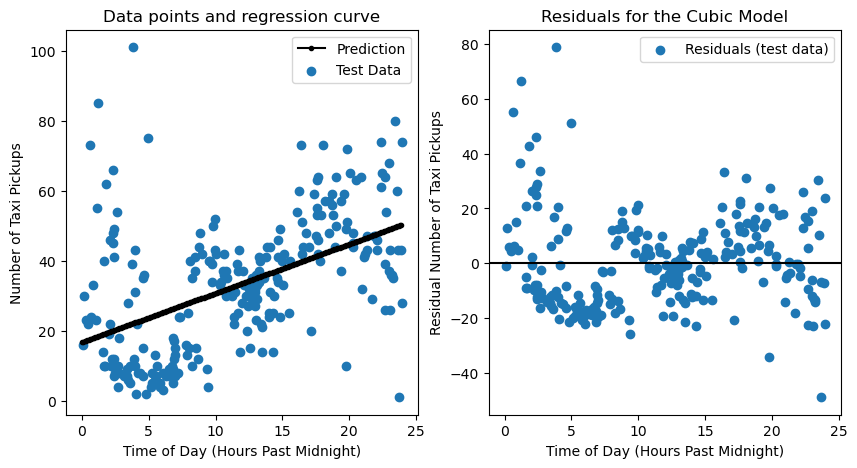

In [28]:
plot_cabs(fitted_cab_model0)

R2 score on the training set shows us that the model is not capable of explaining the data very well. 
It is not a surprise that score on the test set is also quite low.

In [29]:
fitted_cab_model0.score(X_train, y_train)

0.2430260353189334

In [30]:
fitted_cab_model0.score(X_test, y_test)

0.240661535615741

We can see that there's still a lot of variation in cab pickups that's not being caught by a linear fit. And the linear fit is predicting massively more pickups at 11:59pm than at 12:00am. However, we can add columns to our design matrix for $TimeMin^2$ and $TimeMin^3$ and so on, allowing a wigglier polynomial that will better fit the data.

We'll be using sklearn's `PolynomialFeatures` to take some of the tedium out of building the new design matrix. In fact, if all we want is a formula like $y \approx \beta_0 + \beta_1 x + \beta_2 x^2 + ...$ it will directly return the new design matrix.

In [31]:
transformer_3 = PolynomialFeatures(3, include_bias=False)
new_features = transformer_3.fit_transform(X_train)
new_features

array([[6.73333333e+00, 4.53377778e+01, 3.05274370e+02],
       [2.18333333e+00, 4.76694444e+00, 1.04078287e+01],
       [1.41666667e+00, 2.00694444e+00, 2.84317130e+00],
       ...,
       [1.96666667e+01, 3.86777778e+02, 7.60662963e+03],
       [1.17333333e+01, 1.37671111e+02, 1.61534104e+03],
       [1.42000000e+01, 2.01640000e+02, 2.86328800e+03]])

A few notes on `PolynomialFeatures`:

- The interface is a bit strange. `PolynomialFeatures` is a 'transformer' in sklearn. We'll be using several transformers that learn a transformation on the training data and then apply that transformation on future data. On these (more typical) transformers it makes sense to have a `.fit()` and a separate `.transform()`. With PolynomialFeatures, the `.fit()` is pretty trivial, and we often fit and transform in one command, as seen above.
- You rarely want to `include_bias` (a column of all 1s), since sklearn will add it automatically and statsmodels can just `add_constant` right before you fit to the design matrix
- If you want polynomial features for a several different variables, you should call `.fit_transform()` separately on each column and append all the results to the design matrix (unless you also want interaction terms between the newly-created features). See `np.concatenate` for joining arrays.

Now we have the new features, let's fit a new model:

C:\Users\tdrumond\AppData\Local\Temp\ipykernel_12888\1318629703.py:39: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


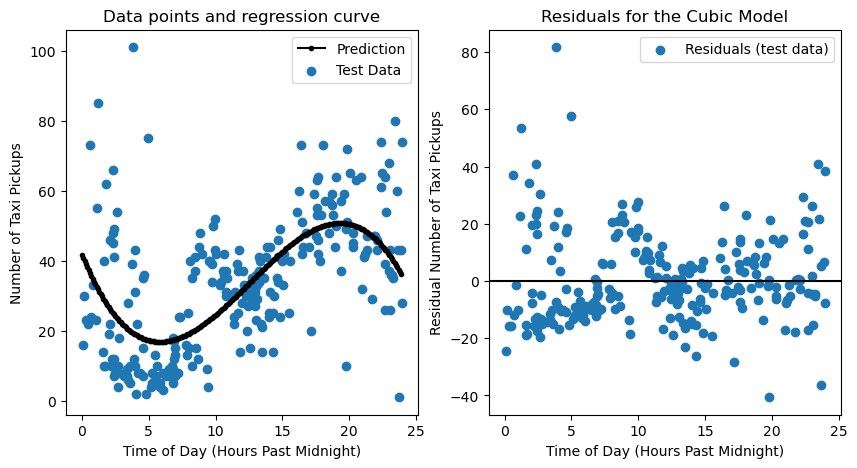

In [32]:
fitted_cab_model3 = LinearRegression().fit(new_features, y_train)
plot_cabs(fitted_cab_model3, transformer_3)


<div class="alert alert-info">
<div class="exercise"><b>

## Exercise

</b></div>

**Questions**:
1. Calculate the polynomial model's $R^2$ performance on the test set. 
2. Does the polynomial model improve on the purely linear model?
3. Compare the residual plot for the polynomial model to that of the linear model. On which hours did the polynomial model help the most with reducing error?

</div>

*your answer here*

#### Other features
Polynomial features are not the only constucted features that help fit the data. Because these data have a 24 hour cycle, we may want to build features that follow such a cycle. For example, $sin(24\frac{x}{2\pi})$, $sin(12\frac{x}{2\pi})$, $sin(8\frac{x}{2\pi})$. Other feature transformations are appropriate to other types of data. For instance certain feature transformations have been developed for geographical data.

<hr style="height:3px">

# Part 2: Multiple regression and exploring the Football data
Let's move on to a truly interesting dataset. The data imported below were scraped by [Shubham Maurya](https://www.kaggle.com/mauryashubham/linear-regression-to-predict-market-value/data) and record various facts about players in the English Premier League. Our goal will be to fit models that predict the players' market value (what the player could earn when hired by a new team), as estimated by transfermrkt.com.

`name`: Name of the player  
`club`: Club of the player  
`age` : Age of the player  
`position` : The usual position on the pitch  
`position_cat` :  1 for attackers, 2 for midfielders, 3 for defenders, 4 for goalkeepers  
`market_value` : As on transfermrkt.com on July 20th, 2017  
`page_views` : Average daily Wikipedia page views from September 1, 2016 to May 1, 2017  
`fpl_value` : Value in Fantasy Premier League as on July 20th, 2017  
`fpl_sel` : % of FPL players who have selected that player in their team  
`fpl_points` : FPL points accumulated over the previous season  
`region`: 1 for England, 2 for EU, 3 for Americas, 4 for Rest of World  
`nationality`: Player's nationality  
`new_foreign`: Whether a new signing from a different league, for 2017/18 (till 20th July)  
`age_cat`: a categorical version of the Age feature  
`club_id`: a numerical version of the Club feature  
`big_club`: Whether one of the Top 6 clubs  
`new_signing`: Whether a new signing for 2017/18 (till 20th July)  

As always, we first import, verify, split, and explore the data.



## Part 2.1: Import and verification and grouping

This cell loads the data and prints:
- the data type of each column
- the first few dataframe rows

In [35]:
league_df = pd.read_csv("league_data.txt").dropna()
print(league_df.dtypes)
league_df.head()

name             object
club             object
age               int64
position         object
position_cat      int64
market_value    float64
page_views        int64
fpl_value       float64
fpl_sel          object
fpl_points        int64
region          float64
nationality      object
new_foreign       int64
age_cat           int64
club_id           int64
big_club          int64
new_signing       int64
dtype: object


,name,club,age,position,position_cat,market_value,page_views,fpl_value,fpl_sel,fpl_points,region,nationality,new_foreign,age_cat,club_id,big_club,new_signing
0,Alexis Sanchez,Arsenal,28,LW,1,65.0,4329,12.0,17.10%,264,3.0,Chile,0,4,1,1,0
1,Mesut Ozil,Arsenal,28,AM,1,50.0,4395,9.5,5.60%,167,2.0,Germany,0,4,1,1,0
2,Petr Cech,Arsenal,35,GK,4,7.0,1529,5.5,5.90%,134,2.0,Czech Republic,0,6,1,1,0
3,Theo Walcott,Arsenal,28,RW,1,20.0,2393,7.5,1.50%,122,1.0,England,0,4,1,1,0
4,Laurent Koscielny,Arsenal,31,CB,3,22.0,912,6.0,0.70%,121,2.0,France,0,4,1,1,0


Here we check the size of the table (rows, columns):

In [36]:
league_df.shape

(460, 17)

The pandas function `.describe()` shows some summary statistics for each columns:

In [17]:
league_df.describe()

,age,position_cat,market_value,page_views,fpl_value,fpl_points,region,new_foreign,age_cat,club_id,big_club,new_signing
count,461.000000,461.000000,461.000000,461.000000,461.000000,461.000000,460.000000,461.000000,461.000000,461.000000,461.000000,461.000000
mean,26.804772,2.180043,11.012039,763.776573,5.447939,57.314534,1.993478,0.034707,3.206074,10.334056,0.303688,0.145336
std,3.961892,1.000061,12.257403,931.805757,1.346695,53.113811,0.957689,0.183236,1.279795,5.726475,0.460349,0.352822
min,17.000000,1.000000,0.050000,3.000000,4.000000,0.000000,1.000000,0.000000,1.000000,1.000000,0.000000,0.000000
25%,24.000000,1.000000,3.000000,220.000000,4.500000,5.000000,1.000000,0.000000,2.000000,6.000000,0.000000,0.000000
50%,27.000000,2.000000,7.000000,460.000000,5.000000,51.000000,2.000000,0.000000,3.000000,10.000000,0.000000,0.000000
75%,30.000000,3.000000,15.000000,896.000000,5.500000,94.000000,2.000000,0.000000,4.000000,15.000000,1.000000,0.000000
max,38.000000,4.000000,75.000000,7664.000000,12.500000,264.000000,4.000000,1.000000,6.000000,20.000000,1.000000,1.000000


### (Stratified) train/test split
We want to make sure that the training and test data have appropriate representation of each region; it would be bad for the training data to entirely miss a region. This is especially important because some regions are rather rare.
<div class="alert alert-info">
<div class="exercise"><b>

#### 👉 Exercise

</b></div>

Use the `train_test_split` function to and its 'stratify' argument to split the data, keeping equal representation of each region 

</div>

*your answer here*:


Now that we won't be peeking at the test set, let's explore and look for patterns! We'll introduce a number of useful pandas and numpy functions along the way. 

### Groupby
Pandas' `.groupby()` function is a wonderful tool for data analysis. It allows us to analyze each of several subgroups.

Many times, `.groupby()` is combined with `.agg()` to get a summary statistic for each subgroup. For instance: What is the average market value, median page views, and maximum fpl for each player position?

In [20]:
train_data.groupby('position').agg({
    'market_value': np.mean,
    'page_views': np.median,
    'fpl_points': np.max
})

,market_value,page_views,fpl_points
position,,,
AM,24.365385,1413.0,199
CB,8.673016,305.0,178
CF,14.302885,794.5,224
CM,11.115000,428.5,225
DM,13.314815,564.0,105
GK,7.759722,437.5,149
LB,7.608333,362.5,135
LM,3.541667,325.5,99
LW,13.551667,488.5,264


You can see all posible values for `postion` appear in the resulting table.

In [21]:
train_data.position.unique()

array(['RW', 'CM', 'CF', 'LB', 'DM', 'CB', 'GK', 'LW', 'LM', 'RB', 'SS',
       'AM', 'RM'], dtype=object)

We can also group by pairs of values (two different columns):

In [22]:
train_data.groupby(['big_club', 'position']).agg({
    'market_value': np.mean,
    'page_views': np.mean,
    'fpl_points': np.mean
})

market_value   page_views  fpl_points
big_club position                                       
0        AM           11.678571   554.571429   64.571429
         CB            4.475000   310.727273   40.727273
         CF            8.678571   862.028571   61.114286
         CM            6.345588   339.323529   37.823529
         DM            7.312500   461.562500   35.250000
         GK            4.467391   390.000000   50.652174
         LB            5.284091   260.954545   50.818182
         LM            3.250000   321.800000   55.600000
         LW            6.300000   434.950000   53.150000
         RB            4.137500   235.700000   49.900000
         RM            4.333333   280.333333    1.666667
         RW            8.087500   550.400000   47.850000
         SS            8.625000  2343.000000   67.750000
1        AM           39.166667  2580.166667  135.000000
         CB           18.394737   987.210526   72.736842
         CF           25.882353  2222.764706   78.588235
         CM           21.250000  1502.312500   75.875000
         DM           22.045455  1380.454545   72.000000
         GK           13.584615   859.461538   67.076923
         LB           14.000000   612.750000   62.000000
         LM            5.000000   936.000000   26.000000
         LW           28.055000  2055.700000  100.000000
         RB           12.785714   889.142857   75.571429
         RM           18.000000  2537.000000  105.000000
         RW           32.000000  1110.400000   60.800000
         SS           38.000000  2196.000000  180.000000

<hr style="height:3px">

## Part 2.2: Linear regression on the football data
This section of the lab focuses on fitting a model to the football data and interpreting the model results. The model we'll use is:

$$\text{market\_value} \approx \beta_0 + \beta_1\text{fpl\_points} + \beta_2\text{age} + \beta_3\text{age}^2 + \beta_4 log_2 \left(\text{page\_views}\right) + \beta_5\text{new\_signing} +\beta_6\text{big\_club} + \beta_7\text{position\_cat}$$

We're including a 2nd degree polynomial in age because we expect pay to increase as a player gains experience, but then decrease as they continue aging. We're taking the log of page views because they have such a large, skewed range and the transformed variable will have fewer outliers that could bias the line. We choose the base of the log to be 2 just to make interpretation cleaner.

<div class="alert alert-info">
<div class="exercise"><b>

#### 👉 Exercise

</b></div>

**Questions**:
1. Build a design matrix function and fit this model to the training data. How good is the overall model?
2. Interpret the regression model. What is the meaning of the coefficient for:
    - age and age $^2$
    - $log_2($ page_views $)$
    - big_club
2. What should a player do in order to improve their market value? How many page views should a player go get to increase their market value by 10?

</div>

In [ ]:
#TODO: your code here

TODO: *your answer here*


<hr style='height:3px'>

## Part 2.3: Turning Categorical Variables into multiple binary variables
Of course, we have an error in how we've included player position. Even though the variable is numeric (1,2,3,4) and the model runs without issue, the value we're getting back is garbage. The interpretation, such as it is, is that there is an equal effect of moving from position category 1 to 2, from 2 to 3, and from 3 to 4, and that this effect is about -.61.

In reality, we don't expect moving from one position category to another to be equivalent, nor for a move from category 1 to category 3 to be twice as important as a move from category 1 to category 2. We need to introduce better features to model this variable.

We'll use `pd.get_dummies` to do the work for us.

In [27]:
train_design_recoded = pd.get_dummies(train_design, columns=['position_cat'], drop_first=True)
test_design_recoded = pd.get_dummies(test_design, columns=['position_cat'], drop_first=True)

train_design_recoded.head()

,const,fpl_points,age,age_squared,log_views,new_signing,big_club,position_cat_2,position_cat_3,position_cat_4
307,1.0,126,23,529,9.463524,1,0,0,0,0
259,1.0,0,22,484,10.100662,0,1,0,0,0
446,1.0,71,30,900,8.731319,0,0,1,0,0
360,1.0,52,25,625,8.754888,0,0,1,0,0
336,1.0,79,36,1296,11.375039,0,0,0,0,0


We've removed the original `position_cat` column and created three new ones.

<div class="alert ">

#### ❓ Why only three new columns?
Why does pandas give us the option to drop the first category? 
</div>



<div class="alert alert-info">
<div class="exercise"><b>

#### 👉 Exercise

</b></div>

**Questions**:
1. If we're fitting a model without a constant, should we have three dummy columns or four dummy columns?
2. Fit a model and interpret the coefficient of `position_cat_2`.
</div>

# Part 3: A nice trick for forward-backwards

XOR (operator ^) is a logical operation that only returns true when input differ. We can use it to implement forward-or-backwards selection when we want to keep track of whet predictors are "left" from a given list of predictors.

The set analog is "symmetric difference". From the python docs:

`s.symmetric_difference(t)	s ^ t	new set with elements in either s or t but not both`


In [31]:
set() ^ set([1,2,3])

{1, 2, 3}

In [32]:
set([1]) ^ set([1,2,3])

{2, 3}

In [33]:
set([1, 2]) ^ set([1,2,3])

{3}

<div class="alert alert-info">
<div class="exercise"><b>

#### 👉 Exercise

</b></div>

Outline a step-forwards algorithm which uses this idea

</div>

*your answer here*
